# Clustering of segment-wise features extracted from inertial data

## Import and data loading

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import umap

import distinctipy

In [2]:
import sklearn
print("sklearn version: ", sklearn.__version__)
print("umap version:    ", umap.__version__)

sklearn version:  0.23.2
umap version:     0.5.2


In [3]:
# load pre-computed features, see 02_features.ipynb for feature computation
features = pd.read_pickle("../data_example/features.pickle")
print(features.shape)
features.head(5)

(44322, 240)


,duration,duration_log10,gx_mean,gy_mean,gz_mean,ax_G_mean,ay_G_mean,az_G_mean,ax_R_mean,ay_R_mean,...,ay_R-12.5-15.0,ay_R-15.0-17.5,ay_R-17.5-20.0,az_R-2.5-5.0,az_R-5.0-7.5,az_R-7.5-10.0,az_R-10.0-12.5,az_R-12.5-15.0,az_R-15.0-17.5,az_R-17.5-20.0
window_id,,,,,,,,,,,,,,,,,,,,,
20211213_AM-RF010-02-0000000-0000070,0.233333,-0.632023,5.388096,-96.104213,20.470755,-0.310028,-0.061163,0.926053,-0.059288,0.020549,...,1.583186,1.207794,0.952565,1.306413,2.044864,2.219286,2.251206,2.039940,1.347810,0.995425
20211213_AM-RF010-02-0000070-0000139,0.230000,-0.638272,-104.087277,176.059446,229.363925,-0.504969,0.022706,0.827898,-0.077429,0.087445,...,2.080025,1.595939,1.218814,0.896903,1.837985,1.377899,1.080420,1.214959,1.053174,1.035958
20211213_AM-RF010-02-0000139-0000457,1.060000,0.025306,-9.406132,19.914543,11.214346,-0.878373,0.121919,0.440244,-0.004789,-0.012189,...,1.659699,1.596681,2.101854,0.629112,1.387521,2.174146,2.553905,1.840422,1.532189,1.626089
20211213_AM-RF010-02-0000457-0000484,0.090000,-1.045757,-194.665414,258.532489,311.274776,-0.828119,0.520349,0.118917,0.013404,0.122724,...,2.472512,2.273956,1.518944,1.904977,2.245000,2.269050,2.260076,2.321367,2.197916,1.415656
20211213_AM-RF010-02-0000484-0000672,0.626667,-0.202963,-6.638547,-17.302168,-12.135769,-0.682197,0.673070,0.268674,-0.031853,-0.057635,...,1.293964,1.545884,1.794298,1.241897,1.699145,1.580130,0.926240,0.933520,0.947048,1.379653


Note: The window ID (index of the dataframe) is an unique identifier for each segment resulting from the changepoint detection pipeline.

It has format YYYYMMDD_session-animal-block-`iloc_start`-`iloc_end`, where `iloc_start` and `iloc_end` correspond to the index of start and end of the segment in the IMU recording. 

## Clustering pipeline

### Outlier detection
Here we use a robust scaler to detect abnormal segments which may prevent the Gaussian Mixture Model from converging. You can have a look at the [PyOD package](https://pyod.readthedocs.io/en/latest/) for alternative solutions.

In [4]:
threshold_exclusion = 35
abs_robust = np.abs(RobustScaler().fit_transform(features.values))
is_outlier = np.any(abs_robust > threshold_exclusion, axis=1)

# Exclude putative wet-dog-shakes along with segments immediately before and immediately after them
is_putative_wds = is_outlier & (features.gyr_norm_mean.values > 600) & (features.gyr_energy.values > 20000) & (features.duration.values < 1)
is_outlier = is_outlier | np.append(False, is_putative_wds[:-1]) | np.append(is_putative_wds[1:], False)

### z-score and PCA
The dimensionality for PCA was selected using FactoMineR's [estim_ncp](https://www.rdocumentation.org/packages/FactoMineR/versions/2.9/topics/estim_ncp) function. Alternatively you can use other heuristics such as the fraction of explained variance.

In [5]:
d = 30  # dimensionality for PCA

# zscoring
scaler = StandardScaler().fit(features[~is_outlier])
features_zscored = scaler.transform(features)

# PCA decomposition
pca = PCA(n_components=d, random_state=42).fit(features_zscored[~is_outlier])
features_pca = pca.transform(features_zscored)

features_pca.shape

(44322, 30)

### GMM clustering

In [6]:
%%time
# GMM hyperparameters, obtained by BIC maximization
K = 48
random_state = 48
covariance_type = "full"

# Fit the GMM
gmm = GaussianMixture(n_components=K, covariance_type=covariance_type,
                      random_state=random_state).fit(features_pca[~is_outlier])

# Cluster assignment, -1 for outliers
cluster = np.full(len(features), -1)
cluster[~is_outlier] = gmm.predict(features_pca[~is_outlier])
cluster = pd.Series(cluster, index=features.index, name="cluster")

cluster.head(10)

CPU times: user 9min 59s, sys: 15.9 s, total: 10min 15s
Wall time: 33.7 s


window_id
20211213_AM-RF010-02-0000000-0000070    23
20211213_AM-RF010-02-0000070-0000139    27
20211213_AM-RF010-02-0000139-0000457     7
20211213_AM-RF010-02-0000457-0000484    29
20211213_AM-RF010-02-0000484-0000672    30
20211213_AM-RF010-02-0000672-0000787    44
20211213_AM-RF010-02-0000787-0001090    20
20211213_AM-RF010-02-0001090-0001254    45
20211213_AM-RF010-02-0001254-0001328    23
20211213_AM-RF010-02-0001328-0001775     9
Name: cluster, dtype: int64

## UMAP visualization

In [7]:
%%time
u = umap.UMAP(n_neighbors=8,
              random_state=45,
              n_components=2,
              target_weight=1e-9,
              min_dist=1e-3)

features_umap = pd.DataFrame(u.fit_transform(features_zscored, y=cluster),
                             columns=["umap1", "umap2"],
                             index=features.index)

features_umap.head(5)

CPU times: user 2min, sys: 10.5 s, total: 2min 10s
Wall time: 1min 26s


,umap1,umap2
window_id,,
20211213_AM-RF010-02-0000000-0000070,6.712887,9.327984
20211213_AM-RF010-02-0000070-0000139,13.217298,8.116311
20211213_AM-RF010-02-0000139-0000457,5.873304,4.540504
20211213_AM-RF010-02-0000457-0000484,7.254629,-3.651906
20211213_AM-RF010-02-0000484-0000672,7.060894,0.061664


## Summary table

### Create summary table

In [8]:
# Probability to belong to each cluster
P = pd.DataFrame(gmm.predict_proba(features_pca),
                 columns=[f"{c:02d}" for c in range(K)],
                 index=features.index)

# Add additional columns
P["is_outlier"] = is_outlier
P = P.join(cluster).join(features_umap)

P.head(5)

,00,01,02,03,04,05,06,07,08,09,...,42,43,44,45,46,47,is_outlier,cluster,umap1,umap2
window_id,,,,,,,,,,,,,,,,,,,,,
20211213_AM-RF010-02-0000000-0000070,3.939141e-109,1.399035e-10,4.906325e-18,1.806571e-09,1.096338e-11,2.091981e-47,0.000000e+00,2.918334e-38,5.175782e-12,1.718494e-290,...,1.666338e-82,7.825868e-97,1.755275e-23,7.076011e-14,2.888507e-31,2.981904e-03,False,23,6.712887,9.327984
20211213_AM-RF010-02-0000070-0000139,3.824481e-127,3.469690e-04,1.274510e-239,7.281480e-133,7.270660e-299,4.545592e-43,0.000000e+00,2.927278e-173,1.387838e-23,0.000000e+00,...,1.949818e-247,7.675681e-230,1.701743e-302,7.155577e-74,9.602335e-134,2.927910e-25,False,27,13.217298,8.116311
20211213_AM-RF010-02-0000139-0000457,4.018126e-28,2.148496e-112,3.009277e-142,9.263651e-12,7.390712e-109,2.512514e-30,3.133540e-299,9.923768e-01,3.092496e-17,0.000000e+00,...,5.764993e-296,2.081943e-05,2.242806e-117,4.145876e-04,4.958934e-35,7.374486e-19,False,7,5.873304,4.540504
20211213_AM-RF010-02-0000457-0000484,9.184459e-222,6.519575e-81,0.000000e+00,0.000000e+00,0.000000e+00,2.723601e-252,0.000000e+00,0.000000e+00,1.013065e-96,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.875520e-246,0.000000e+00,2.800232e-134,False,29,7.254629,-3.651906
20211213_AM-RF010-02-0000484-0000672,2.297023e-62,5.337706e-111,3.186261e-119,2.154194e-30,1.385986e-91,2.769571e-66,7.743034e-152,2.758539e-32,1.912323e-14,0.000000e+00,...,1.255410e-216,3.427986e-25,1.907378e-57,1.080105e-09,1.303454e-128,3.524977e-17,False,30,7.060894,0.061664


### UMAP scatter plot

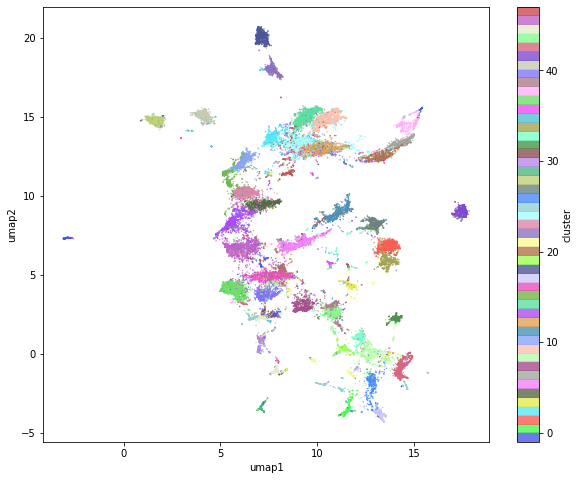

In [9]:
colors = distinctipy.get_colors(K + 1, pastel_factor=.4, rng=42)
cmap = distinctipy.get_colormap(colors)

fig, ax = plt.subplots(figsize=(10, 8))
P.plot(kind="scatter", x="umap1", y="umap2", ax=ax, c="cluster", colorbar=True, cmap=cmap, ec=None, s=2, alpha=.8)

### Same, colored by feature values

In [13]:
# Head roll and pitch
P["mu_roll"] = -np.degrees(np.arctan2(features.attitude_muy, features.attitude_muz))
P["mu_pitch"] = -np.degrees(np.arctan2(-features.attitude_mux,
                                       np.sqrt(features.attitude_muy**2 + features.attitude_muz**2)))


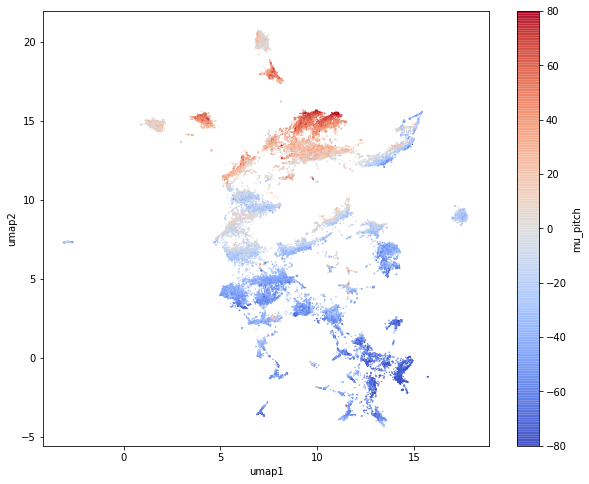

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
P.join(features).plot(kind="scatter", x="umap1", y="umap2",
                      ax=ax, c="mu_pitch", ec=None, cmap="coolwarm",
                      s=2, alpha=.8, vmin=-80, vmax=80)